In [1]:
# Train a CNN regression to predict the mCG level of all DMRs
import pandas as pd
import numpy as np
import time, re
import matplotlib.pyplot as plt

# Quantify mCG at the enhancers

In [2]:
# bed_file='enhancers_reptile.bed'
# allc_dir='/cndd2/fangming/scf_enhancers/data/bulk/round2/mc/'
# allc_files=glob.glob(allc_dir+'Round2*CGN-Merge.allc.tsv.gz')

# # bed_file='foo.bed'
# # allc_files = [allc_files[0]]

# output_files = ['enh.'+os.path.split(a)[1][:-22]+'.bed.gz' for a in allc_files]
# cap = 0 # no counts cap
# nprocs = 8
# compress = True
# bed_file_name_column = False
# chr_prefix = True
# contexts = ['CG']

# run_mc_region_level(allc_files, 
#                     output_files, 
#                     bed_file, 
#                     chr_prefix=chr_prefix,
#                     bed_file_name_column=bed_file_name_column,
#                     contexts=contexts,
#                     compress=compress, 
#                     cap=cap,
#                     nprocs=nprocs);

In [3]:
# # Gather data from all the individual bed files
# df = pd.DataFrame();
# for fn in output_files:
    
#     _, sample = os.path.split(fn)
#     sample = re.sub('(enh\.|\.bed)','',sample)

#     x = pd.read_csv(fn+'.gz',sep='\t')
#     x=x.rename(mapper={'mCG': sample+'_'+'mCG', 'CG': sample+'_'+'CG'}, axis=1)
#     if df.shape[0]<1:
#         df = x
#     else:
#         df = df.join(x.iloc[:,[3,4]])
        
# df['enh_pos'] = 'chr'+df['chr'].astype(str)+'_'+df['start'].astype(str)+'_'+df['end'].astype(str)

In [4]:
# df.to_csv('enh.AllClusters.mCG.bed.gz')

In [5]:
# for fn in output_files:
#     os.remove(fn)
#     print('Removed file %s' % fn)

# Load enhancer data

In [6]:
# Map the genes to closest enhancers
datadir = '/cndd/emukamel/enhancer_modeling/enhancer_data/'
genes2enh = pd.read_csv(datadir+'genes.gencode.vM16.closest_enhancers.bed',sep='\t',
                        names = ['gene_chr','gene_start','gene_end','ensid','gene_name','enh_chr','enh_start','enh_end'])

In [7]:
genes2enh['enh_pos'] = genes2enh['enh_chr']+'_'+genes2enh['enh_start'].astype(str)+'_'+genes2enh['enh_end'].astype(str)

In [8]:
genes2enh.ensid = [re.sub("\..*","",x) for x in genes2enh.ensid]
genes2enh = genes2enh.set_index('ensid')

In [9]:
genes = pd.read_csv(datadir+'genes.gencode.vM16.bed',sep='\t',header=None,
                   names=['chr','start','end','ensid','gene'])
genes['ensid'] = [re.sub('\..*','',ensid) for ensid in genes['ensid']]
genes = genes.set_index('ensid',drop=False)
genes

,chr,start,end,ensid,gene
ensid,,,,,
ENSMUSG00000102693,chr1,3073253,3074322,ENSMUSG00000102693,4933401J01Rik
ENSMUSG00000064842,chr1,3102016,3102125,ENSMUSG00000064842,Gm26206
ENSMUSG00000051951,chr1,3205901,3671498,ENSMUSG00000051951,Xkr4
ENSMUSG00000102851,chr1,3252757,3253236,ENSMUSG00000102851,Gm18956
ENSMUSG00000103377,chr1,3365731,3368549,ENSMUSG00000103377,Gm37180
...,...,...,...,...,...
ENSMUSG00000095134,chrY,90753057,90763485,ENSMUSG00000095134,Mid1-ps1
ENSMUSG00000095366,chrY,90754513,90754821,ENSMUSG00000095366,Gm21860
ENSMUSG00000096768,chrY,90784738,90816464,ENSMUSG00000096768,Erdr1


# Load RNA data

In [10]:
datadir='/cndd2/ethan/projects/scf_paper/modeling/working_data/reptile/data_for_model_01152020/' # 10x vs scRNA
rna = pd.read_csv(datadir+'rna_for_y_values.tsv',sep='\t')
rcol = rna.columns.values
rcol[1] = 'ensid'
rna.columns = rcol
# rna=rna.drop('10-1',axis=1)
# rna_data = rna.iloc[:,2:].to_numpy()

# Variable genes
hvg = np.var(rna.iloc[:,2:].to_numpy(),axis=1);
hvg = hvg> np.percentile(hvg,50)
np.sum(hvg)

rna = rna[hvg]

In [11]:
rna = rna.set_index('ensid')

In [18]:
# Subset to the HVGs
genes2enhu = genes2enh.loc[rna.index]

In [23]:
data.columns.shape

(57,)

In [55]:
# Load different RNA datasets
rnadir = '/cndd/emukamel/BICCN-Mouse-MOp/supp_tables/Table_S5_GeneByCluster/'
rna_modalities = ['Table_S5a_gene_counts_scRNA_SMART.tsv.gz',
    'Table_S5b_gene_counts_scRNA_10X_v3_A.tsv.gz',
    'Table_S5c_gene_counts_scRNA_10X_v2_A.tsv.gz',
    'Table_S5d_gene_counts_snRNA_SMART.tsv.gz',
    'Table_S5e_gene_counts_snRNA_10X_v3_B.tsv.gz',
    'Table_S5f_gene_counts_snRNA_10X_v3_A.tsv.gz',
#     'Table_S5g_gene_counts_open_chromatin.tsv.gz',
#     'Table_S5h_gene_counts_DNA_methylation.xlsx.gz'
    ]

all_rna = {'modality':[], 'data':[], 'celltypes':['1-1-1', '1-2-1', '1-2-2', '10-1-1', '2-1-1', '2-1-2',
       '2-2-1', '2-2-2', '2-2-3', '2-2-4', '2-3-1', '2-3-2', '2-3-3', '3-1-1',
       '3-1-2', '3-2-1', '3-2-2', '3-3-1', '4-1-1', '4-1-2', '4-2-1', '4-2-2',
       '4-2-3', '5-1-1', '5-1-2', '5-2-1', '5-2-2', '5-2-3', '5-3-1', '5-3-2',
       '5-4-1', '5-5-1', '6-1-1', '6-1-2', '6-2-1', '6-3-1', '6-3-2', '6-3-3',
       '6-4-1', '6-4-2', '6-5-1', '6-5-2', '6-5-3', '6-6-1', '7-1-1', '7-1-2',
       '7-2-1', '7-2-2', '8-1-1', '8-1-2', '8-2-1', '8-3-1', '8-3-2', '9-1-1',
       '9-2-1', '9-2-2']}
scf_l2 = ['1-1-1', '1-2-1', '1-2-2', '10-1-1', '2-1-1', '2-1-2',
       '2-2-1', '2-2-2', '2-2-3', '2-2-4', '2-3-1', '2-3-2', '2-3-3', '3-1-1',
       '3-1-2', '3-2-1', '3-2-2', '3-3-1', '4-1-1', '4-1-2', '4-2-1', '4-2-2',
       '4-2-3', '5-1-1', '5-1-2', '5-2-1', '5-2-2', '5-2-3', '5-3-1', '5-3-2',
       '5-4-1', '5-5-1', '6-1-1', '6-1-2', '6-2-1', '6-3-1', '6-3-2', '6-3-3',
       '6-4-1', '6-4-2', '6-5-1', '6-5-2', '6-5-3', '6-6-1', '7-1-1', '7-1-2',
       '7-2-1', '7-2-2', '8-1-1', '8-1-2', '8-2-1', '8-3-1', '8-3-2', '9-1-1',
       '9-2-1', '9-2-2']
scf_l1,scf_l1i = np.unique(np.array([re.sub('-[0-9]$','', i) for i in scf_l2]),return_inverse=True)
scf_l1,scf_l1i

rna_modalities = 'Table_S5b_gene_counts_scRNA_10X_v3_A.tsv.gz'
fn = rnadir+ds
data_l2 = pd.read_csv(fn,sep='\t',nrows=100,index_col=0)
data_l1 = data_l2.loc[:,[]]
for i in range(len(scf_l1)):
    data_l1.loc[:,scf_l1[i]] = data_l2.iloc[:,scf_l1i==i].sum(axis=1)
data_l1

,1-1,1-2,10-1,2-1,2-2,2-3,3-1,3-2,3-3,4-1,...,6-4,6-5,6-6,7-1,7-2,8-1,8-2,8-3,9-1,9-2
ENSMUSG00000051951,54331,34776,2849,105663,60324,16182,86593,66870,196,56461,...,9949,3968,700,5352,13660,10301,8077,816,2906,2122
ENSMUSG00000089699,4431,2933,287,8416,4705,1312,7140,5589,18,5180,...,880,350,77,449,1299,718,523,48,206,182
ENSMUSG00000102343,73,15,0,56,40,9,71,44,0,66,...,3,2,0,0,7,6,1,1,6,13
ENSMUSG00000025900,227,104,6,249,110,71,245,248,1,324,...,12,13,1,17,21,20,4,0,20,20
ENSMUSG00000025902,1,0,0,10,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000097934,39,17,8,41,27,19,58,50,0,70,...,0,1,0,6,7,1,0,0,3,7
ENSMUSG00000025931,1208,529,13,1566,804,642,1505,1266,5,1229,...,20,51,5,76,113,47,80,103,208,308
ENSMUSG00000041809,100,46,0,73,30,22,134,152,0,136,...,3,2,0,5,13,15,0,1,20,16
ENSMUSG00000041779,134,79,1,80,24,22,65,70,1,99,...,9,2,0,4,8,14,3,0,3,6


In [45]:
re.sub

<function re.sub(pattern, repl, string, count=0, flags=0)>

In [37]:
for ds in rna_modalities:
    fn = rnadir+ds
    print(fn)
    data = pd.read_csv(fn,sep='\t',nrows=100,index_col=0)
#     print(data.head())

    data = data.loc[:,all_rna['celltypes']]
    data = genes2enhu.join(data)
#     print(np.setdiff1d(data.index, genes2enhu.index).shape)
#     data = data.loc[genes2enhu.index.values,:]
    all_rna['modality'].append(fn)
    all_rna['data'].append(data)

/cndd/emukamel/BICCN-Mouse-MOp/supp_tables/Table_S5_GeneByCluster/Table_S5a_gene_counts_scRNA_SMART.tsv.gz
/cndd/emukamel/BICCN-Mouse-MOp/supp_tables/Table_S5_GeneByCluster/Table_S5b_gene_counts_scRNA_10X_v3_A.tsv.gz
/cndd/emukamel/BICCN-Mouse-MOp/supp_tables/Table_S5_GeneByCluster/Table_S5c_gene_counts_scRNA_10X_v2_A.tsv.gz
/cndd/emukamel/BICCN-Mouse-MOp/supp_tables/Table_S5_GeneByCluster/Table_S5d_gene_counts_snRNA_SMART.tsv.gz
/cndd/emukamel/BICCN-Mouse-MOp/supp_tables/Table_S5_GeneByCluster/Table_S5e_gene_counts_snRNA_10X_v3_B.tsv.gz
/cndd/emukamel/BICCN-Mouse-MOp/supp_tables/Table_S5_GeneByCluster/Table_S5f_gene_counts_snRNA_10X_v3_A.tsv.gz


In [43]:
all_rna['data'][1].columns

Index(['gene_chr', 'gene_start', 'gene_end', 'gene_name', 'enh_chr',
       'enh_start', 'enh_end', 'enh_pos', '1-1-1', '1-2-1', '1-2-2', '10-1-1',
       '2-1-1', '2-1-2', '2-2-1', '2-2-2', '2-2-3', '2-2-4', '2-3-1', '2-3-2',
       '2-3-3', '3-1-1', '3-1-2', '3-2-1', '3-2-2', '3-3-1', '4-1-1', '4-1-2',
       '4-2-1', '4-2-2', '4-2-3', '5-1-1', '5-1-2', '5-2-1', '5-2-2', '5-2-3',
       '5-3-1', '5-3-2', '5-4-1', '5-5-1', '6-1-1', '6-1-2', '6-2-1', '6-3-1',
       '6-3-2', '6-3-3', '6-4-1', '6-4-2', '6-5-1', '6-5-2', '6-5-3', '6-6-1',
       '7-1-1', '7-1-2', '7-2-1', '7-2-2', '8-1-1', '8-1-2', '8-2-1', '8-3-1',
       '8-3-2', '9-1-1', '9-2-1', '9-2-2'],
      dtype='object')

# Load mCG data

In [14]:
datadir = '/cndd/emukamel/enhancer_modeling/enhancer_data/'
df = pd.read_csv(datadir+'enh.AllClusters.mCG.bed.gz')
df['enh_pos'] = 'chr'+df['chr'].astype(str)+'_'+df['start'].astype(str)+'_'+df['end'].astype(str)
df = df.drop(['Unnamed: 0'],axis=1)
df

/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,chr,start,end,Round2.3-3_mCG,Round2.3-3_CG,Round2.8-2_mCG,Round2.8-2_CG,Round2.2-1_mCG,Round2.2-1_CG,Round2.6-1_mCG,...,Round2.5-5_CG,Round2.2-2_mCG,Round2.2-2_CG,Round2.6-4_mCG,Round2.6-4_CG,Round2.4-1_mCG,Round2.4-1_CG,Round2.6-2_mCG,Round2.6-2_CG,enh_pos
0,1,3083769,3083816,1,1,5,5,31,32,13,...,0,18,20,2,3,15,16,13,14,chr1_3083769_3083816
1,1,3112234,3112467,15,16,27,28,304,315,57,...,0,174,177,15,67,149,164,37,118,chr1_3112234_3112467
2,1,3112770,3112986,0,0,1,4,49,53,7,...,0,30,33,1,10,24,33,6,18,chr1_3112770_3112986
3,1,3113717,3114035,8,14,9,16,35,206,44,...,3,16,125,15,59,55,115,10,95,chr1_3113717_3114035
4,1,3118790,3118935,12,14,2,2,93,130,21,...,0,46,56,14,29,42,89,5,48,chr1_3118790_3118935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302091,X,169890644,169890829,2,2,10,10,62,70,0,...,0,39,40,2,16,30,37,1,43,chrX_169890644_169890829
302092,X,169918008,169918093,2,2,3,3,26,26,0,...,0,14,15,0,5,6,6,5,7,chrX_169918008_169918093
302093,X,169927115,169927682,6,35,75,79,243,709,44,...,5,306,412,89,94,204,417,318,340,chrX_169927115_169927682
302094,X,169935048,169935204,3,3,8,9,45,48,17,...,0,31,32,7,7,27,30,25,28,chrX_169935048_169935204


In [16]:
# Compute mCH level
cg = df.iloc[:,3:-1:2]
mcg = df.iloc[:,4:-1:2]
mlevel = mcg.to_numpy() / cg.to_numpy()
hthresh = 2
mlevel[ cg<hthresh ] = np.nan

df_mlevel = pd.DataFrame(mlevel, columns = cg.columns, index=df.enh_pos)

/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/cndd/emukamel/conda_envs/scanpy/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


Round2.3-3_mCG     False
Round2.8-2_mCG      True
Round2.2-1_mCG      True
Round2.6-1_mCG      True
Round2.4-2_mCG      True
Round2.1-1_mCG      True
Round2.10-1_mCG    False
Round2.3-2_mCG      True
Round2.7-2_mCG      True
Round2.5-1_mCG      True
Round2.8-3_mCG     False
Round2.6-6_mCG     False
Round2.9-1_mCG     False
Round2.3-1_mCG      True
Round2.1-2_mCG      True
Round2.5-2_mCG      True
Round2.7-1_mCG      True
Round2.5-4_mCG     False
Round2.2-3_mCG      True
Round2.9-2_mCG     False
Round2.6-5_mCG      True
Round2.6-3_mCG      True
Round2.5-3_mCG      True
Round2.8-1_mCG      True
Round2.5-5_mCG     False
Round2.2-2_mCG      True
Round2.6-4_mCG      True
Round2.4-1_mCG      True
Round2.6-2_mCG      True
dtype: bool

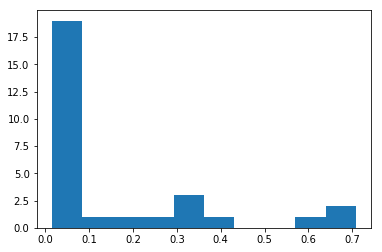

In [26]:
plt.hist((cg<hthresh).mean(axis=0))
good_celltypes = (cg<hthresh).mean(axis=0)<0.2
good_celltypes

In [27]:
celltypes = df_mlevel.columns
celltypes = [re.sub("(Round2\.|_mCG)","",c) for c in celltypes]
df_mlevel.columns = celltypes

In [28]:
# Cell type names
df_cellnames = pd.read_csv('/cndd/Public_Datasets/CEMBA/BICCN_minibrain_data/data_freeze/supp_info/clusters_final/cluster_annotation_scf_round2.tsv',
                       sep='\t', index_col='cluster')

# Load ATAC data

In [29]:
atac = pd.read_csv(datadir+'enhancers_reptile_atac_norm.tsv',sep='\t')
atac=atac.set_index('enhancer_idx',drop=False)
atac_enh_list = pd.read_csv(datadir+'enhancers_reptile.bed',sep='\t',header=None,names=['chr','start','end'])
atac = atac.join(atac_enh_list)
atac['enh_pos'] = atac['chr'].astype(str)+'_'+atac['start'].astype(str)+'_'+atac['end'].astype(str)
atac = atac.loc[~(atac['chr']=="chrY")]
df_atac = atac.set_index('enh_pos',drop=False)

In [30]:
# Make sure the ATAC and mCG data are both in the same column order
df_atac = df_atac[celltypes]
df_mlevel = df_mlevel[celltypes]

In [73]:
celltypes = df_mlevel.columns
celltypes = [re.sub("(Round2\.|_mCG)","",c) for c in celltypes]

# Kmers

In [74]:
kdict=np.load(datadir+'kmers_6mers/kmer_dict.npy', allow_pickle=True)

In [75]:
# Load the kmer data per enhancer
kmer_counts=np.load(datadir+'kmers_6mers/count.npy')

In [76]:
kmer_enh = pd.read_csv(datadir+'enhancers_reptile.bed', sep='\t', 
                       header=None, names=['chr','start','end'])
kmer_enh['enh_pos'] = ['_'.join([str(i) for i in row]) for ind,row in kmer_enh.iterrows()]

In [77]:
kmer_enh['enh_num'] = np.arange(kmer_enh.shape[0])

In [78]:
kmer_enh = kmer_enh.set_index('enh_pos', drop=False)
kmer_counts.shape

(302106, 2080)

# Prepare the data and save

In [99]:
# Make sure all data frames have the cell types in the same order
enh_posu = genes2enhu['enh_pos'].unique()
df_mlevelu = df_mlevel.loc[enh_posu]
df_atacu = df_atac.loc[enh_posu]
df_mlevel.shape, df_mlevelu.shape

((302096, 29), (142890, 29))

In [100]:
# Determine the enhancer number for each gene-enhancer pair
genes2enhu = genes2enh.loc[rna.index]  # Note that this is larger than df_mlevelu
genes2enhu['enh_num'] = kmer_enh.loc[genes2enhu['enh_pos'],'enh_num'].values

In [101]:
kmer_countsu = kmer_counts[genes2enhu['enh_num'],:]

In [102]:
# Drop the bad cell types
bad_celltypes = cg.columns[((cg<hthresh).mean(axis=0)>0.2)]
bad_celltypes = [i.replace('Round2.','').replace('_mCG','') for i in bad_celltypes]
rnau = rna.drop(bad_celltypes,axis=1).drop(['Unnamed: 0'],axis=1)
df_mlevelu = df_mlevelu.loc[:,rnau.columns]
df_atacu = df_atacu.loc[:,rnau.columns]
assert( (rnau.columns==df_mlevelu.columns).all() )
assert( (rnau.columns==df_atacu.columns).all() )
df_mlevelu.shape, df_atacu.shape

((142890, 21), (142890, 21))

In [ ]:
# Save the data needed for training
fn_save_prefix = 'RegressData/Regress_data_%dgenes_%dcells_' % (rnau.shape[0], rnau.shape[1])
save_vars = ['genes2enhu', 'rnau', 'df_mlevelu', 'df_atacu','genes']
for var in save_vars:
    fn_save = fn_save_prefix+var+'.pkl'
    eval(var).to_pickle(fn_save)
    print(fn_save)
np.savez_compressed('RegressData/Regress_Feb16_data_kmer_countsu.npz', kmer_countsu=kmer_countsu)
print(fn_save_prefix +'kmer_countsu.pkl')

RegressData/Regress_data_9868genes_21cells_genes2enhu.pkl
RegressData/Regress_data_9868genes_21cells_rnau.pkl
RegressData/Regress_data_9868genes_21cells_df_mlevelu.pkl
RegressData/Regress_data_9868genes_21cells_df_atacu.pkl
RegressData/Regress_data_9868genes_21cells_genes.pkl


In [ ]:
# Impute the NaN values in mlevel
df_mlevelu_mean = np.outer(df_mlevelu.median(axis=1).values, df_mlevelu.median(axis=0).values)
df_mlevelu_mean = pd.DataFrame(df_mlevelu_mean, index=df_mlevelu.index, columns=df_mlevelu.columns)
df_mlevelu_mean = df_mlevelu_mean.fillna(df_mlevelu.median())
df_mlevelu = df_mlevelu.fillna(df_mlevelu_mean)
assert(not df_mlevelu.isna().any(axis=None))
assert(not df_atacu.isna().any(axis=None))
ensids = rnau.index.values

In [ ]:
# Filter out bad enhancers
bad_enh = df_mlevelu.loc[genes2enhu.loc[:,'enh_pos']].isna().any(axis=1)
bad_enh = bad_enh | df_atacu.loc[genes2enhu.loc[:,'enh_pos']].isna().any(axis=1)
good_enh = [not i for i in bad_enh]
genes2enhu = genes2enhu[good_enh]
genes2enhu['enh_num2'] = np.arange(genes2enhu.shape[0])
kmer_countsu = kmer_countsu[good_enh]
K = kmer_countsu.shape[1] # Number of K-mers

In [ ]:
# Gather all the mC and ATAC data into a numpy array for quick indexing
# %%timeit
ensids = rnau.index.values
max_nenh = genes2enhu.groupby('ensid')['gene_chr'].count().max()
Ne = ensids.shape[0]
Nc = df_mlevelu.shape[1]
rna_lookup = rnau.loc[ensids].to_numpy()
ml_lookup = np.zeros((Ne,max_nenh,Nc))
atac_lookup = np.zeros((Ne,max_nenh,Nc))
kmeri_lookup = [];
for i,ens in enumerate(ensids):
    curr_enh = genes2enhu.loc[ens,['enh_pos','enh_num2']]
    mlu = df_mlevelu.loc[curr_enh['enh_pos']].to_numpy()
    atacu = df_atacu.loc[curr_enh['enh_pos']]
    ml_lookup[i,:mlu.shape[0],:] = mlu
    atac_lookup[i,:atacu.shape[0],:] = atacu
    kmeri_lookup.append(curr_enh['enh_num2'].values)

In [ ]:
np.savez_compressed(fn_save_prefix+'AllLookups.npz',
                   ml_lookup=ml_lookup,
                   atac_lookup=atac_lookup,
                   rna_lookup=rna_lookup,
                   kmeri_lookup=kmeri_lookup)